In [1]:
import os
import sqlite3
import pandas as pd

# Function to load restaurant data
def load_restaurant_data(db_file, db_id, c, m=50):
    """Load and calculate weighted ratings for restaurant data from specified database."""
    if not os.path.exists(db_file):
        print(f"Error: {db_file} does not exist.")
        return pd.DataFrame()

    queries = {
        "deliveroo": f"""
            SELECT 
                name AS restaurant_name, 
                address, postal_code, uname,
                CAST(longitude AS REAL) AS longitude, 
                CAST(latitude AS REAL) AS latitude, 
                rating, CAST(rating_number AS INTEGER) AS rating_number,
                ((rating_number * rating) + ({m} * {c})) / (rating_number + {m}) AS weighted_rating,
                prep_time, delivery_time, min_order, delivery_fee,
                (CAST(delivery_fee AS REAL) + CAST(min_order AS REAL)) AS combined_cost
            FROM restaurants
            WHERE rating IS NOT NULL AND rating_number > 0 AND delivery_fee IS NOT NULL AND min_order IS NOT NULL
        """,
        "takeaway": f"""
            SELECT 
                r.name AS restaurant_name, 
                r.address, r.city, r.primarySlug AS restaurant_id,
                CAST(r.longitude AS REAL) AS longitude, 
                CAST(r.latitude AS REAL) AS latitude, 
                r.ratings AS rating, CAST(r.ratingsNumber AS INTEGER) AS rating_number,
                ((r.ratingsNumber * r.ratings) + ({m} * {c})) / (r.ratingsNumber + {m}) AS weighted_rating,
                l.postalCode AS postal_code,
                CAST(r.deliveryFee AS REAL) AS delivery_fee, CAST(r.minOrder AS REAL) AS min_order,
                (CAST(r.deliveryFee AS REAL) + CAST(r.minOrder AS REAL)) AS combined_cost
            FROM restaurants r
            LEFT JOIN (
                SELECT
                    lr.restaurant_id, l.postalCode
                FROM locations_to_restaurants lr
                JOIN locations l ON lr.location_id = l.ID
                WHERE l.postalCode IS NOT NULL
            ) l ON r.primarySlug = l.restaurant_id
            WHERE r.ratings IS NOT NULL AND r.ratingsNumber > 0 AND r.deliveryFee IS NOT NULL AND r.minOrder IS NOT NULL
        """
    }

    try:
        conn = sqlite3.connect(db_file)
        df = pd.read_sql_query(queries[db_id], conn)
        if df.empty:
            print(f"Warning: No data from {db_id}.")
        df['longitude'] = df['longitude'].round(6)
        df['latitude'] = df['latitude'].round(6)
        df['source'] = db_id
        return df
    except sqlite3.OperationalError as e:
        print(f"Error with {db_id}: {e}")
        return pd.DataFrame()
    finally:
        conn.close()

# Define database files and identifiers
db_files = [
    ("databases_uc/deliveroo.db", "deliveroo"),
    ("databases_uc/takeaway.db", "takeaway")
]

# Load and combine data
dataframes = [load_restaurant_data(file, db_id, c=4.0, m=50) for file, db_id in db_files]
stacked_df = pd.concat(dataframes, ignore_index=True)

# Fill missing values
stacked_df['city'] = stacked_df.get('city', pd.Series()).fillna("Unknown")
stacked_df['postal_code'] = stacked_df.get('postal_code', pd.Series()).fillna("Unknown")
stacked_df['address'] = stacked_df['address'].fillna("Unknown")
stacked_df['rating'] = stacked_df['rating'].fillna(0.0)

# Ensure delivery_fee and min_order are numeric
stacked_df['delivery_fee'] = pd.to_numeric(stacked_df['delivery_fee'], errors='coerce').fillna(0)
stacked_df['min_order'] = pd.to_numeric(stacked_df['min_order'], errors='coerce').fillna(0)

# Filter out restaurants where both delivery_fee and min_order are 0
stacked_df = stacked_df[(stacked_df['delivery_fee'] > 0) | (stacked_df['min_order'] > 0)]

# Drop duplicates based on restaurant_name, address, rating, and source
stacked_df = stacked_df.drop_duplicates(subset=['restaurant_name', 'address', 'rating_number', 'source'])

# Normalize restaurant names for merging
stacked_df['normalized_name'] = stacked_df['restaurant_name'].str.strip().str.lower()

# Separate data by platform
deliveroo_df = stacked_df[stacked_df['source'] == 'deliveroo']
takeaway_df = stacked_df[stacked_df['source'] == 'takeaway']

# Merge data on normalized names
mutual_df = pd.merge(
    deliveroo_df,
    takeaway_df,
    on='normalized_name',
    suffixes=('_deliveroo', '_takeaway')
)

# Select relevant columns for the analysis
mutual_analysis_df = mutual_df[[
    'normalized_name',
    'rating_deliveroo', 'rating_takeaway',
    'rating_number_deliveroo', 'rating_number_takeaway',
    'delivery_fee_deliveroo', 'delivery_fee_takeaway',
    'min_order_deliveroo', 'min_order_takeaway',
    'combined_cost_deliveroo', 'combined_cost_takeaway',
    'city_deliveroo', 'city_takeaway',
    'postal_code_deliveroo', 'postal_code_takeaway'
]]

# Display mutual analysis dataframe
print(mutual_analysis_df.head())


  normalized_name  rating_deliveroo  rating_takeaway  rating_number_deliveroo  \
0        bia mara               4.3              4.1                      121   
1        bia mara               4.3              4.3                      121   
2   balls & glory               4.5              4.6                      500   
3   balls & glory               4.5              4.2                      500   
4   balls & glory               4.5              3.9                      500   

   rating_number_takeaway  delivery_fee_deliveroo  delivery_fee_takeaway  \
0                      13                    4.99                   5.59   
1                      83                    4.99                   2.99   
2                       6                    4.99                   3.49   
3                      96                    4.99                   4.84   
4                     182                    4.99                   4.84   

   min_order_deliveroo  min_order_takeaway  combined_cos

Total rows after processing: 5319
               restaurant_name                     address postal_code  \
59738  De Echte Eethuis Carlos       Herseltsesteenweg 207        2230   
8438                 Veziroglu  Franklin Rooseveltlaan 100        1800   
2633            Snack Thieffry              Rue Pervyse 62        1140   
4068                 Sushiline     Chaussée De Louvain 470        1140   
60904              Snack Dekan   Place Cardinal Mercier 41        1731   

          unique_restaurant_id  longitude   latitude  rating  rating_count  \
59738  eethuis-carlos-aarschot   4.835920  51.002308     5.0           599   
8438                 veziroglu   4.425172  50.931044     5.0           455   
2633            snack-thieffry   4.399869  50.830792     4.9          3875   
4068       sushiline-bruxelles   4.391012  50.853172     4.9          3036   
60904              snack-dekan   4.329693  50.880092     4.9          2845   

       weighted_rating  prep_time  delivery_time  to

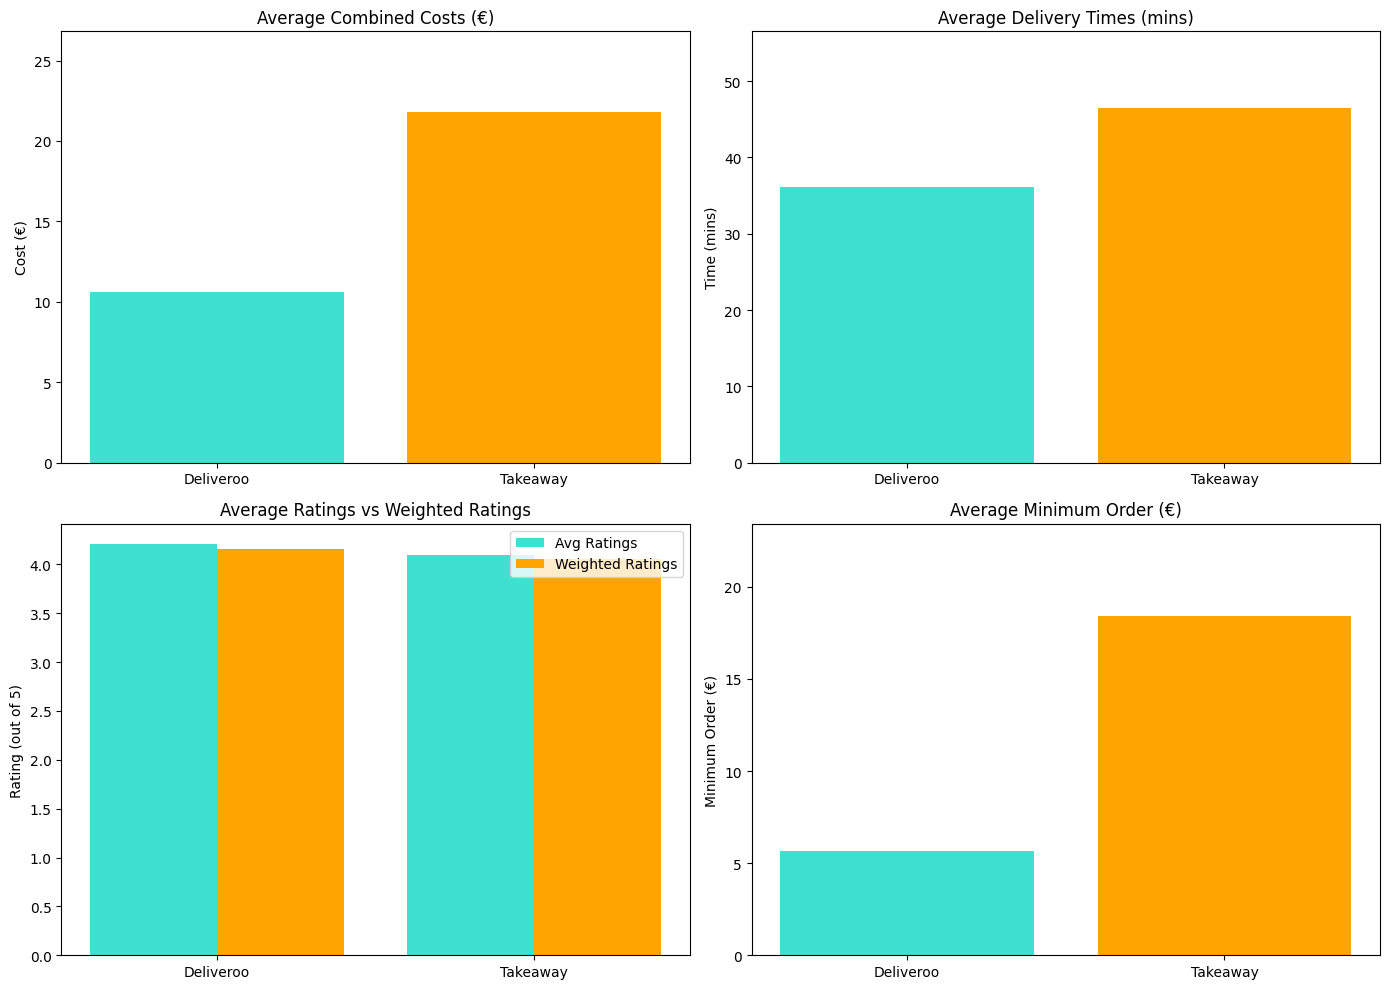

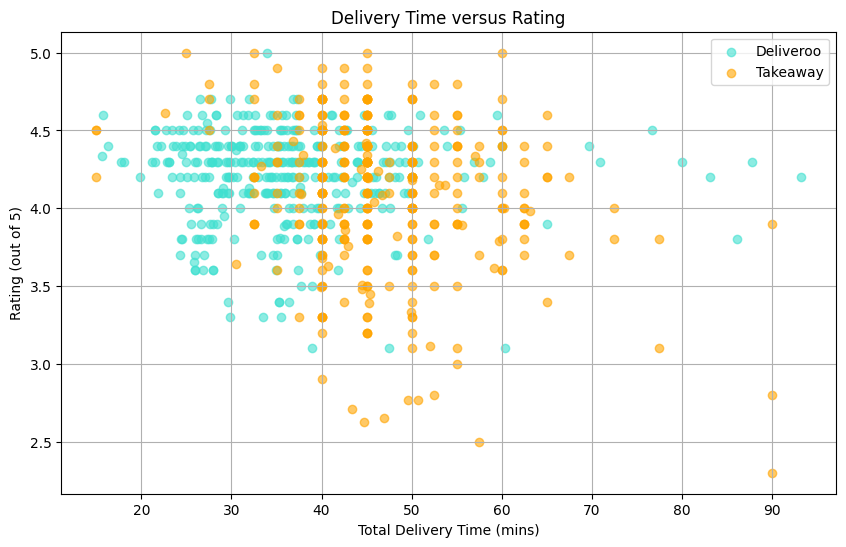

In [24]:
import os
import sqlite3
import pandas as pd

def load_restaurant_data(db_file, db_id, c, m=50):
    """Load and calculate weighted ratings for restaurant data from specified database."""
    if not os.path.exists(db_file):
        print(f"Error: {db_file} does not exist.")
        return pd.DataFrame()

    # Define queries for each database
    queries = {
        "deliveroo": f"""
            SELECT 
                name AS restaurant_name, 
                address, postal_code, uname AS unique_restaurant_id,
                CAST(longitude AS REAL) AS longitude, 
                CAST(latitude AS REAL) AS latitude, 
                rating, CAST(rating_number AS INTEGER) AS rating_count,
                ((rating_number * rating) + ({m} * {c})) / (rating_number + {m}) AS weighted_rating,
                prep_time, delivery_time, 
                ROUND(CAST(prep_time AS REAL) + CAST(delivery_time AS REAL), 2) AS total_delivery_time,
                COALESCE(delivery_fee, 0) AS delivery_fee, 
                COALESCE(min_order, 0) AS min_order,
                ROUND(COALESCE(CAST(delivery_fee AS REAL), 0) + COALESCE(CAST(min_order AS REAL), 0), 2) AS combined_cost
            FROM restaurants
            WHERE rating IS NOT NULL 
              AND rating_number > 0
              AND (delivery_fee IS NOT NULL OR min_order IS NOT NULL)
        """,
        "takeaway": f"""
            SELECT 
                r.name AS restaurant_name, 
                r.address, r.city, r.primarySlug AS unique_restaurant_id,
                CAST(r.longitude AS REAL) AS longitude, 
                CAST(r.latitude AS REAL) AS latitude, 
                r.ratings AS rating, CAST(r.ratingsNumber AS INTEGER) AS rating_count,
                ((r.ratingsNumber * r.ratings) + ({m} * {c})) / (r.ratingsNumber + {m}) AS weighted_rating,
                l.postalCode AS postal_code,
                COALESCE(r.deliveryFee, 0) AS delivery_fee, 
                COALESCE(r.minOrder, 0) AS min_order,
                ROUND(COALESCE(CAST(r.deliveryFee AS REAL), 0) + COALESCE(CAST(r.minOrder AS REAL), 0), 2) AS combined_cost,
                ROUND((CAST(r.durationRangeMin AS REAL) + CAST(r.durationRangeMax AS REAL)) / 2, 2) AS total_delivery_time
            FROM restaurants r
            LEFT JOIN (
                SELECT
                    lr.restaurant_id, l.postalCode
                FROM locations_to_restaurants lr
                JOIN locations l ON lr.location_id = l.ID
                WHERE l.postalCode IS NOT NULL
            ) l ON r.primarySlug = l.restaurant_id
            WHERE r.ratings IS NOT NULL 
              AND r.ratingsNumber > 0
        """
    }

    try:
        # Connect to the database and execute the query
        conn = sqlite3.connect(db_file)
        df = pd.read_sql_query(queries[db_id], conn)
        if df.empty:
            print(f"Warning: No data found in {db_id}.")
        df['source'] = db_id  # Add source identifier
        return df
    except sqlite3.OperationalError as e:
        print(f"Error querying {db_id}: {e}")
        return pd.DataFrame()
    finally:
        conn.close()

# Define database files and identifiers
db_files = [
    ("databases_uc/deliveroo.db", "deliveroo"),
    ("databases_uc/takeaway.db", "takeaway")
]

# Load and combine data
dataframes = [load_restaurant_data(file, db_id, c=4.0, m=50) for file, db_id in db_files]
stacked_df = pd.concat(dataframes, ignore_index=True)

# Fill missing values
stacked_df['city'] = stacked_df.get('city', pd.Series()).fillna("Unknown")
stacked_df['postal_code'] = stacked_df.get('postal_code', pd.Series()).fillna("Unknown")
stacked_df['address'] = stacked_df['address'].fillna("Unknown")
stacked_df['rating'] = stacked_df['rating'].fillna(0.0)
stacked_df['delivery_fee'] = stacked_df['delivery_fee'].fillna(0.0)
stacked_df['min_order'] = stacked_df['min_order'].fillna(0.0)
stacked_df['total_delivery_time'] = stacked_df['total_delivery_time'].fillna("Unknown")
stacked_df['combined_cost'] = stacked_df['combined_cost'].fillna(0.0)

# Drop duplicates based on restaurant name and source
stacked_df = stacked_df.drop_duplicates(subset=['restaurant_name', 'address', 'source'])

# Sort by weighted_rating
stacked_df = stacked_df.sort_values(by='weighted_rating', ascending=False)

# Display the processed data
print(f"Total rows after processing: {stacked_df.shape[0]}")
print(stacked_df.head())




# Calculate average delivery fee for both platforms
avg_delivery_fee_deliveroo = data['delivery_fee_deliveroo'].mean()
avg_delivery_fee_takeaway = data['delivery_fee_takeaway'].mean()

# Calculate average minimum order for both platforms
avg_min_order_deliveroo = data['min_order_deliveroo'].mean()
avg_min_order_takeaway = data['min_order_takeaway'].mean()

# Calculate average rating for both platforms
avg_rating_deliveroo = data['rating_deliveroo'].mean()
avg_rating_takeaway = data['rating_takeaway'].mean()

print(f"Average Delivery Fee (Deliveroo): {avg_delivery_fee_deliveroo:.2f}€")
print(f"Average Delivery Fee (Takeaway): {avg_delivery_fee_takeaway:.2f}€")
print(f"Average Minimum Order (Deliveroo): {avg_min_order_deliveroo:.2f}€")
print(f"Average Minimum Order (Takeaway): {avg_min_order_takeaway:.2f}€")
print(f"Average Rating (Deliveroo): {avg_rating_deliveroo:.2f}")
print(f"Average Rating (Takeaway): {avg_rating_takeaway:.2f}")
# Calculate average delivery time for both platforms
avg_delivery_time_deliveroo = data['total_delivery_time_deliveroo'].mean()
avg_delivery_time_takeaway = data['total_delivery_time_takeaway'].mean()

print(f"Average Delivery Time (Deliveroo): {avg_delivery_time_deliveroo:.2f} mins")
print(f"Average Delivery Time (Takeaway): {avg_delivery_time_takeaway:.2f} mins")


import matplotlib.pyplot as plt

# Data for plotting
platforms = ['Deliveroo', 'Takeaway']
avg_costs = [avg_combined_cost_deliveroo, avg_combined_cost_takeaway]
avg_delivery_times = [avg_delivery_time_deliveroo, avg_delivery_time_takeaway]
avg_ratings = [avg_rating_deliveroo, avg_rating_takeaway]
weighted_ratings = [weighted_ratings[0], weighted_ratings[1]]
min_order_means = [avg_min_order_deliveroo, avg_min_order_takeaway]

# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot Average Combined Costs
axes[0, 0].bar(platforms, avg_costs, color=['turquoise', 'orange'])
axes[0, 0].set_title('Average Combined Costs (€)')
axes[0, 0].set_ylabel('Cost (€)')
axes[0, 0].set_ylim(0, max(avg_costs) + 5)

# Plot Average Delivery Times
axes[0, 1].bar(platforms, avg_delivery_times, color=['turquoise', 'orange'])
axes[0, 1].set_title('Average Delivery Times (mins)')
axes[0, 1].set_ylabel('Time (mins)')
axes[0, 1].set_ylim(0, max(avg_delivery_times) + 10)

# Plot Ratings (Average and Weighted)
x = [0, 1]  # X positions for the platforms
axes[1, 0].bar(x, avg_ratings, width=0.4, label='Avg Ratings', color='turquoise', align='center')
axes[1, 0].bar([i + 0.4 for i in x], weighted_ratings, width=0.4, label='Weighted Ratings', color='orange', align='center')
axes[1, 0].set_title('Average Ratings vs Weighted Ratings')
axes[1, 0].set_xticks([i + 0.2 for i in x])
axes[1, 0].set_xticklabels(platforms)
axes[1, 0].set_ylabel('Rating (out of 5)')
axes[1, 0].legend()

# Plot Average Minimum Order Value
axes[1, 1].bar(platforms, min_order_means, color=['turquoise', 'orange'])
axes[1, 1].set_title('Average Minimum Order (€)')
axes[1, 1].set_ylabel('Minimum Order (€)')
axes[1, 1].set_ylim(0, max(min_order_means) + 5)

plt.tight_layout()
plt.show()

# Scatter Plot for Delivery Time vs Ratings
plt.figure(figsize=(10, 6))
plt.scatter(data['total_delivery_time_deliveroo'], data['rating_deliveroo'], color='turquoise', label='Deliveroo', alpha=0.6)
plt.scatter(data['total_delivery_time_takeaway'], data['rating_takeaway'], color='orange', label='Takeaway', alpha=0.6)
plt.title('Delivery Time versus Rating')
plt.xlabel('Total Delivery Time (mins)')
plt.ylabel('Rating (out of 5)')
plt.legend()
plt.grid(True)
plt.show()

In [2]:
import os
import sqlite3
import pandas as pd

# Function to load restaurant data
def load_restaurant_data(db_file, db_id, c, m=50):
    """Load and calculate weighted ratings for restaurant data from specified database."""
    if not os.path.exists(db_file):
        print(f"Error: {db_file} does not exist.")
        return pd.DataFrame()

    queries = {
        "deliveroo": f"""
            SELECT 
                name AS restaurant_name, 
                address, postal_code, uname,
                CAST(longitude AS REAL) AS longitude, 
                CAST(latitude AS REAL) AS latitude, 
                rating, CAST(rating_number AS INTEGER) AS rating_number,
                ((rating_number * rating) + ({m} * {c})) / (rating_number + {m}) AS weighted_rating,
                prep_time, delivery_time, min_order, delivery_fee,
                (CAST(delivery_fee AS REAL) + CAST(min_order AS REAL)) AS combined_cost,
                (CAST(prep_time AS REAL) + CAST(delivery_time AS REAL)) AS total_delivery_time
            FROM restaurants
            WHERE rating IS NOT NULL AND rating_number > 0 AND delivery_fee IS NOT NULL AND min_order IS NOT NULL
        """,
        "takeaway": f"""
            SELECT 
                r.name AS restaurant_name, 
                r.address, r.city, r.primarySlug AS restaurant_id,
                CAST(r.longitude AS REAL) AS longitude, 
                CAST(r.latitude AS REAL) AS latitude, 
                r.ratings AS rating, CAST(r.ratingsNumber AS INTEGER) AS rating_number,
                ((r.ratingsNumber * r.ratings) + ({m} * {c})) / (r.ratingsNumber + {m}) AS weighted_rating,
                l.postalCode AS postal_code,
                CAST(r.deliveryFee AS REAL) AS delivery_fee, CAST(r.minOrder AS REAL) AS min_order,
                (CAST(r.deliveryFee AS REAL) + CAST(r.minOrder AS REAL)) AS combined_cost,
                CAST(r.durationRangeMin AS REAL) + CAST(r.durationRangeMax AS REAL) / 2 AS total_delivery_time
            FROM restaurants r
            LEFT JOIN (
                SELECT
                    lr.restaurant_id, l.postalCode
                FROM locations_to_restaurants lr
                JOIN locations l ON lr.location_id = l.ID
                WHERE l.postalCode IS NOT NULL
            ) l ON r.primarySlug = l.restaurant_id
            WHERE r.ratings IS NOT NULL AND r.ratingsNumber > 0 AND r.deliveryFee IS NOT NULL AND r.minOrder IS NOT NULL
        """
    }

    try:
        conn = sqlite3.connect(db_file)
        df = pd.read_sql_query(queries[db_id], conn)
        if df.empty:
            print(f"Warning: No data from {db_id}.")
        df['longitude'] = df['longitude'].round(6)
        df['latitude'] = df['latitude'].round(6)
        df['source'] = db_id
        return df
    except sqlite3.OperationalError as e:
        print(f"Error with {db_id}: {e}")
        return pd.DataFrame()
    finally:
        conn.close()

# Define database files and identifiers
db_files = [
    ("databases_uc/deliveroo.db", "deliveroo"),
    ("databases_uc/takeaway.db", "takeaway")
]

# Load and combine data
dataframes = [load_restaurant_data(file, db_id, c=4.0, m=50) for file, db_id in db_files]
stacked_df = pd.concat(dataframes, ignore_index=True)

# Normalize restaurant names for merging
stacked_df['normalized_name'] = stacked_df['restaurant_name'].str.strip().str.lower()

# Separate data by platform
deliveroo_df = stacked_df[stacked_df['source'] == 'deliveroo']
takeaway_df = stacked_df[stacked_df['source'] == 'takeaway']

# Merge data on normalized names
mutual_df = pd.merge(
    deliveroo_df,
    takeaway_df,
    on='normalized_name',
    suffixes=('_deliveroo', '_takeaway')
)

# Select relevant columns for the analysis
mutual_analysis_df = mutual_df[[
    'normalized_name',
    'rating_deliveroo', 'rating_takeaway',
    'rating_number_deliveroo', 'rating_number_takeaway',
    'delivery_fee_deliveroo', 'delivery_fee_takeaway',
    'min_order_deliveroo', 'min_order_takeaway',
    'combined_cost_deliveroo', 'combined_cost_takeaway',
    'total_delivery_time_deliveroo', 'total_delivery_time_takeaway',
    'city_deliveroo', 'city_takeaway',
    'postal_code_deliveroo', 'postal_code_takeaway'
]]

# Display the first few rows of the dataframe for validation
print(mutual_analysis_df.head())
# Display mutual analysis dataframe
print(mutual_analysis_df.head())


# Deduplicate based on the combination of "normalized_name", "rating_deliveroo", and "rating_takeaway"
deduplicated_df = mutual_analysis_df.drop_duplicates(subset=['normalized_name', 'rating_deliveroo', 'rating_takeaway'])

# Display the deduplicated dataframe
print(deduplicated_df.head())



  normalized_name  rating_deliveroo  rating_takeaway  rating_number_deliveroo  \
0        bia mara               4.3              4.1                      121   
1        bia mara               4.3              4.1                      121   
2        bia mara               4.3              4.1                      121   
3        bia mara               4.3              4.1                      121   
4        bia mara               4.3              4.1                      121   

   rating_number_takeaway delivery_fee_deliveroo delivery_fee_takeaway  \
0                      13                   4.99                  5.59   
1                      13                   4.99                  5.59   
2                      13                   4.99                  5.59   
3                      13                   4.99                  5.59   
4                      13                   4.99                  5.59   

  min_order_deliveroo min_order_takeaway  combined_cost_deliveroo  \

In [3]:
import os
import sqlite3
import pandas as pd

# Function to load restaurant data
def load_restaurant_data(db_file, db_id, c, m=50):
    """Load and calculate weighted ratings for restaurant data from specified database."""
    if not os.path.exists(db_file):
        print(f"Error: {db_file} does not exist.")
        return pd.DataFrame()

    # Define queries for each database
    queries = {
        "deliveroo": f"""
            SELECT 
                name AS restaurant_name, 
                address, postal_code, uname AS unique_restaurant_id,
                CAST(longitude AS REAL) AS longitude, 
                CAST(latitude AS REAL) AS latitude, 
                rating, CAST(rating_number AS INTEGER) AS rating_count,
                ((rating_number * rating) + ({m} * {c})) / (rating_number + {m}) AS weighted_rating,
                prep_time, delivery_time, 
                ROUND(CAST(prep_time AS REAL) + CAST(delivery_time AS REAL), 2) AS total_delivery_time,
                COALESCE(delivery_fee, 0) AS delivery_fee, 
                COALESCE(min_order, 0) AS min_order,
                ROUND(COALESCE(CAST(delivery_fee AS REAL), 0) + COALESCE(CAST(min_order AS REAL), 0), 2) AS combined_cost
            FROM restaurants
            WHERE rating IS NOT NULL 
              AND rating_number > 0
              AND (delivery_fee IS NOT NULL OR min_order IS NOT NULL)
        """,
        "takeaway": f"""
            SELECT 
                r.name AS restaurant_name, 
                r.address, r.city, r.primarySlug AS unique_restaurant_id,
                CAST(r.longitude AS REAL) AS longitude, 
                CAST(r.latitude AS REAL) AS latitude, 
                r.ratings AS rating, CAST(r.ratingsNumber AS INTEGER) AS rating_count,
                ((r.ratingsNumber * r.ratings) + ({m} * {c})) / (r.ratingsNumber + {m}) AS weighted_rating,
                l.postalCode AS postal_code,
                COALESCE(r.deliveryFee, 0) AS delivery_fee, 
                COALESCE(r.minOrder, 0) AS min_order,
                ROUND(COALESCE(CAST(r.deliveryFee AS REAL), 0) + COALESCE(CAST(r.minOrder AS REAL), 0), 2) AS combined_cost,
                ROUND((CAST(r.durationRangeMin AS REAL) + CAST(r.durationRangeMax AS REAL)) / 2, 2) AS total_delivery_time
            FROM restaurants r
            LEFT JOIN (
                SELECT
                    lr.restaurant_id, l.postalCode
                FROM locations_to_restaurants lr
                JOIN locations l ON lr.location_id = l.ID
                WHERE l.postalCode IS NOT NULL
            ) l ON r.primarySlug = l.restaurant_id
            WHERE r.ratings IS NOT NULL 
              AND r.ratingsNumber > 0
        """
    }

    try:
        conn = sqlite3.connect(db_file)
        df = pd.read_sql_query(queries[db_id], conn)
        df['longitude'] = df['longitude'].round(6)
        df['latitude'] = df['latitude'].round(6)
        df['source'] = db_id
        return df
    except sqlite3.OperationalError as e:
        print(f"Error loading data from {db_id}: {e}")
        return pd.DataFrame()
    finally:
        conn.close()

# Define database files
db_files = [
    ("databases_uc/deliveroo.db", "deliveroo"),
    ("databases_uc/takeaway.db", "takeaway")
]

# Load and combine data from both databases
dataframes = [load_restaurant_data(file, db_id, c=4.0, m=50) for file, db_id in db_files]
df_ratings = pd.concat(dataframes, ignore_index=True)

# Normalize restaurant names
df_ratings['restaurant_name_clean'] = df_ratings['restaurant_name'].str.lower().str.strip()

# Convert relevant columns to numeric
numeric_columns = [
    'rating', 'rating_count', 'weighted_rating',
    'delivery_fee', 'min_order', 'combined_cost', 'total_delivery_time'
]
for column in numeric_columns:
    df_ratings[column] = pd.to_numeric(df_ratings[column], errors='coerce')

# Identify cross-platform restaurants
cross_platform = df_ratings.groupby('restaurant_name_clean').filter(lambda x: x['source'].nunique() > 1)

# Pivot the data to consolidate metrics into one dataframe
mutual_analysis_df = cross_platform.pivot_table(
    index='restaurant_name_clean',
    columns='source',
    values=numeric_columns,
    aggfunc='mean'
)

# Flatten the columns for clarity
mutual_analysis_df.columns = [f"{metric}_{platform}" for metric, platform in mutual_analysis_df.columns]

# Reset index for better usability
mutual_analysis_df.reset_index(inplace=True)

# Display and export the mutual analysis dataframe
print("\nMutual Analysis DataFrame:")
print(mutual_analysis_df.head())

mutual_analysis_df.to_csv("mutual_analysis_combined.csv", index=False)





Mutual Analysis DataFrame:
  restaurant_name_clean  combined_cost_deliveroo  combined_cost_takeaway  \
0              #falafel                     9.99                   19.84   
1        acqua e farina                     9.99                   35.00   
2         africalicious                     9.99                   50.00   
3                 agora                     9.99                   40.00   
4               akdeniz                     9.99                   19.84   

   delivery_fee_deliveroo  delivery_fee_takeaway  min_order_deliveroo  \
0                    4.99                   4.84                  5.0   
1                    4.99                   0.00                  5.0   
2                    4.99                   0.00                  5.0   
3                    4.99                   0.00                  5.0   
4                    4.99                   4.84                  5.0   

   min_order_takeaway  rating_deliveroo  rating_takeaway  \
0               

In [4]:
import os
import sqlite3
import pandas as pd

# Function to load restaurant data
def load_restaurant_data(db_file, db_id, c=4.0, m=50):
    """Load and calculate weighted ratings for restaurant data from specified database."""
    if not os.path.exists(db_file):
        print(f"Error: {db_file} does not exist.")
        return pd.DataFrame()

    # Define queries for each database
    queries = {
        "deliveroo": """
            SELECT 
                name AS restaurant_name, 
                address, postal_code, uname AS unique_restaurant_id,
                CAST(longitude AS REAL) AS longitude, 
                CAST(latitude AS REAL) AS latitude, 
                rating, CAST(rating_number AS INTEGER) AS rating_count,
                ((rating_number * rating) + (? * ?)) / (rating_number + ?) AS weighted_rating,
                prep_time, delivery_time, 
                ROUND(CAST(prep_time AS REAL) + CAST(delivery_time AS REAL), 2) AS total_delivery_time,
                COALESCE(delivery_fee, 0) AS delivery_fee, 
                COALESCE(min_order, 0) AS min_order,
                ROUND(COALESCE(CAST(delivery_fee AS REAL), 0) + COALESCE(CAST(min_order AS REAL), 0), 2) AS combined_cost
            FROM restaurants
            WHERE rating IS NOT NULL 
              AND rating_number > 0
              AND (delivery_fee IS NOT NULL OR min_order IS NOT NULL)
        """,
        "takeaway": """
            SELECT 
                r.name AS restaurant_name, 
                r.address, r.city, r.primarySlug AS unique_restaurant_id,
                CAST(r.longitude AS REAL) AS longitude, 
                CAST(r.latitude AS REAL) AS latitude, 
                r.ratings AS rating, CAST(r.ratingsNumber AS INTEGER) AS rating_count,
                ((r.ratingsNumber * r.ratings) + (? * ?)) / (r.ratingsNumber + ?) AS weighted_rating,
                l.postalCode AS postal_code,
                COALESCE(r.deliveryFee, 0) AS delivery_fee, 
                COALESCE(r.minOrder, 0) AS min_order,
                ROUND(COALESCE(CAST(r.deliveryFee AS REAL), 0) + COALESCE(CAST(r.minOrder AS REAL), 0), 2) AS combined_cost,
                ROUND((CAST(r.durationRangeMin AS REAL) + CAST(r.durationRangeMax AS REAL)) / 2, 2) AS total_delivery_time
            FROM restaurants r
            LEFT JOIN (
                SELECT
                    lr.restaurant_id, l.postalCode
                FROM locations_to_restaurants lr
                JOIN locations l ON lr.location_id = l.ID
                WHERE l.postalCode IS NOT NULL
            ) l ON r.primarySlug = l.restaurant_id
            WHERE r.ratings IS NOT NULL 
              AND r.ratingsNumber > 0
        """
    }

    try:
        conn = sqlite3.connect(db_file)
        df = pd.read_sql_query(queries[db_id], conn, params=(m, c, m))
        df['longitude'] = df['longitude'].round(6)
        df['latitude'] = df['latitude'].round(6)
        df['source'] = db_id
        return df
    except sqlite3.OperationalError as e:
        print(f"Error loading data from {db_id}: {e}")
        return pd.DataFrame()
    finally:
        if conn:
            conn.close()

# Define database files
db_files = [
    ("databases_uc/deliveroo.db", "deliveroo"),
    ("databases_uc/takeaway.db", "takeaway")
]

# Load and combine data from both databases
dataframes = [load_restaurant_data(file, db_id, c=4.0, m=50) for file, db_id in db_files]
df_ratings = pd.concat(dataframes, ignore_index=True)

# Normalize restaurant names
df_ratings['restaurant_name_clean'] = df_ratings['restaurant_name'].str.lower().str.strip()

# Convert relevant columns to numeric
numeric_columns = [
    'rating', 'rating_count', 'weighted_rating',
    'delivery_fee', 'min_order', 'combined_cost', 'total_delivery_time'
]
for column in numeric_columns:
    df_ratings[column] = pd.to_numeric(df_ratings[column], errors='coerce')

# Identify cross-platform restaurants
cross_platform = df_ratings.groupby('restaurant_name_clean').filter(lambda x: x['source'].nunique() > 1)

# Pivot the data to consolidate metrics into one dataframe
mutual_analysis_df = cross_platform.pivot_table(
    index='restaurant_name_clean',
    columns='source',
    values=numeric_columns,
    aggfunc='mean'
)

# Flatten the columns for clarity
mutual_analysis_df.columns = [f"{metric}_{platform}" for metric, platform in mutual_analysis_df.columns]

# Reset index for better usability
mutual_analysis_df.reset_index(inplace=True)

# Display and export the mutual analysis dataframe
print("\nMutual Analysis DataFrame:")
print(mutual_analysis_df.head())

mutual_analysis_df.to_csv("mutual_analysis_combined.csv", index=False)

# Deduplicate based on restaurant_name_clean, source, and address
df_ratings = df_ratings.drop_duplicates(subset=['restaurant_name_clean', 'source', 'address'])

# Re-identify cross-platform restaurants after deduplication
cross_platform = df_ratings.groupby('restaurant_name_clean').filter(lambda x: x['source'].nunique() > 1)

# Pivot the data again to consolidate metrics into one dataframe
mutual_analysis_df = cross_platform.pivot_table(
    index='restaurant_name_clean',
    columns='source',
    values=numeric_columns,
    aggfunc='mean'
)

# Flatten the columns for clarity
mutual_analysis_df.columns = [f"{metric}_{platform}" for metric, platform in mutual_analysis_df.columns]

# Reset index for better usability
mutual_analysis_df.reset_index(inplace=True)

# Display and export the mutual analysis dataframe
print("\nMutual Analysis DataFrame after deduplication:")
print(mutual_analysis_df.head())

mutual_analysis_df.to_csv("mutual_analysis_combined_deduplicated.csv", index=False)


# Combine deliveroo_df and takeaway_df into a single dataframe
full_data_df = pd.concat([deliveroo_df, takeaway_df], ignore_index=True)

# Display the combined dataframe
print("\nFull Data DataFrame:")
print(full_data_df.head())

# Export the combined dataframe to a CSV file
full_data_df.to_csv("full_data_combined.csv", index=False)


Mutual Analysis DataFrame:
  restaurant_name_clean  combined_cost_deliveroo  combined_cost_takeaway  \
0              #falafel                     9.99                   19.84   
1        acqua e farina                     9.99                   35.00   
2         africalicious                     9.99                   50.00   
3                 agora                     9.99                   40.00   
4               akdeniz                     9.99                   19.84   

   delivery_fee_deliveroo  delivery_fee_takeaway  min_order_deliveroo  \
0                    4.99                   4.84                  5.0   
1                    4.99                   0.00                  5.0   
2                    4.99                   0.00                  5.0   
3                    4.99                   0.00                  5.0   
4                    4.99                   4.84                  5.0   

   min_order_takeaway  rating_deliveroo  rating_takeaway  \
0               

In [5]:
import os
import sqlite3
import pandas as pd

# Function to load restaurant data
def load_restaurant_data(db_file, db_id, c, m=50):
    """Load and calculate weighted ratings for restaurant data from specified database."""
    if not os.path.exists(db_file):
        print(f"Error: {db_file} does not exist.")
        return pd.DataFrame()

    # Define queries for each database
    queries = {
        "deliveroo": f"""
            SELECT 
                name AS restaurant_name, 
                address, postal_code, uname AS unique_restaurant_id,
                CAST(longitude AS REAL) AS longitude, 
                CAST(latitude AS REAL) AS latitude, 
                rating, CAST(rating_number AS INTEGER) AS rating_count,
                ((rating_number * rating) + ({m} * {c})) / (rating_number + {m}) AS weighted_rating,
                prep_time, delivery_time, 
                ROUND(CAST(prep_time AS REAL) + CAST(delivery_time AS REAL), 2) AS total_delivery_time,
                COALESCE(delivery_fee, 0) AS delivery_fee, 
                COALESCE(min_order, 0) AS min_order,
                ROUND(COALESCE(CAST(delivery_fee AS REAL), 0) + COALESCE(CAST(min_order AS REAL), 0), 2) AS combined_cost
            FROM restaurants
            WHERE rating IS NOT NULL 
              AND rating_number > 0
              AND (delivery_fee IS NOT NULL OR min_order IS NOT NULL)
        """,
        "takeaway": f"""
            SELECT 
                r.name AS restaurant_name, 
                r.address, r.city, r.primarySlug AS unique_restaurant_id,
                CAST(r.longitude AS REAL) AS longitude, 
                CAST(r.latitude AS REAL) AS latitude, 
                r.ratings AS rating, CAST(r.ratingsNumber AS INTEGER) AS rating_count,
                ((r.ratingsNumber * r.ratings) + ({m} * {c})) / (r.ratingsNumber + {m}) AS weighted_rating,
                l.postalCode AS postal_code,
                COALESCE(r.deliveryFee, 0) AS delivery_fee, 
                COALESCE(r.minOrder, 0) AS min_order,
                ROUND(COALESCE(CAST(r.deliveryFee AS REAL), 0) + COALESCE(CAST(r.minOrder AS REAL), 0), 2) AS combined_cost,
                ROUND((CAST(r.durationRangeMin AS REAL) + CAST(r.durationRangeMax AS REAL)) / 2, 2) AS total_delivery_time
            FROM restaurants r
            LEFT JOIN (
                SELECT
                    lr.restaurant_id, l.postalCode
                FROM locations_to_restaurants lr
                JOIN locations l ON lr.location_id = l.ID
                WHERE l.postalCode IS NOT NULL
            ) l ON r.primarySlug = l.restaurant_id
            WHERE r.ratings IS NOT NULL 
              AND r.ratingsNumber > 0
        """
    }

    try:
        conn = sqlite3.connect(db_file)
        df = pd.read_sql_query(queries[db_id], conn)
        df['longitude'] = df['longitude'].round(6)
        df['latitude'] = df['latitude'].round(6)
        df['source'] = db_id
        return df
    except sqlite3.OperationalError as e:
        print(f"Error loading data from {db_id}: {e}")
        return pd.DataFrame()
    finally:
        conn.close()

# Define database files
db_files = [
    ("databases_uc/deliveroo.db", "deliveroo"),
    ("databases_uc/takeaway.db", "takeaway")
]

# Load and combine data from both databases
dataframes = [load_restaurant_data(file, db_id, c=4.0, m=50) for file, db_id in db_files]
df_ratings = pd.concat(dataframes, ignore_index=True)

# Normalize restaurant names
df_ratings['restaurant_name_clean'] = df_ratings['restaurant_name'].str.lower().str.strip()

# Convert relevant columns to numeric
numeric_columns = [
    'rating', 'rating_count', 'weighted_rating',
    'delivery_fee', 'min_order', 'combined_cost', 'total_delivery_time'
]
for column in numeric_columns:
    df_ratings[column] = pd.to_numeric(df_ratings[column], errors='coerce')

# Identify cross-platform restaurants
cross_platform = df_ratings.groupby('restaurant_name_clean').filter(lambda x: x['source'].nunique() > 1)

# Pivot the data to consolidate metrics into one dataframe
mutual_analysis_df = cross_platform.pivot_table(
    index='restaurant_name_clean',
    columns='source',
    values=numeric_columns,
    aggfunc='mean'
)

# Flatten the columns for clarity
mutual_analysis_df.columns = [f"{metric}_{platform}" for metric, platform in mutual_analysis_df.columns]

# Reset index for better usability
mutual_analysis_df.reset_index(inplace=True)

# Display and export the mutual analysis dataframe
print("\nMutual Analysis DataFrame:")
print(mutual_analysis_df.head())

mutual_analysis_df.to_csv("mutual_analysis_combined.csv", index=False)




Mutual Analysis DataFrame:
  restaurant_name_clean  combined_cost_deliveroo  combined_cost_takeaway  \
0              #falafel                     9.99                   19.84   
1        acqua e farina                     9.99                   35.00   
2         africalicious                     9.99                   50.00   
3                 agora                     9.99                   40.00   
4               akdeniz                     9.99                   19.84   

   delivery_fee_deliveroo  delivery_fee_takeaway  min_order_deliveroo  \
0                    4.99                   4.84                  5.0   
1                    4.99                   0.00                  5.0   
2                    4.99                   0.00                  5.0   
3                    4.99                   0.00                  5.0   
4                    4.99                   4.84                  5.0   

   min_order_takeaway  rating_deliveroo  rating_takeaway  \
0               

In [6]:
print(mutual_analysis_df)

mutual_analysis_df.to_csv("mutual_analysis.csv", index=False)

    restaurant_name_clean  combined_cost_deliveroo  combined_cost_takeaway  \
0                #falafel                     9.99               19.840000   
1          acqua e farina                     9.99               35.000000   
2           africalicious                     9.99               50.000000   
3                   agora                     9.99               40.000000   
4                 akdeniz                     9.99               19.840000   
..                    ...                      ...                     ...   
350           yammi yammi                     9.99               19.840000   
351        yammy thai wok                     9.99               23.590000   
352                yokoso                     9.99               20.847064   
353                youwok                     9.99               16.226585   
354        zorba de griek                     9.99               15.490000   

     delivery_fee_deliveroo  delivery_fee_takeaway  min_order_d

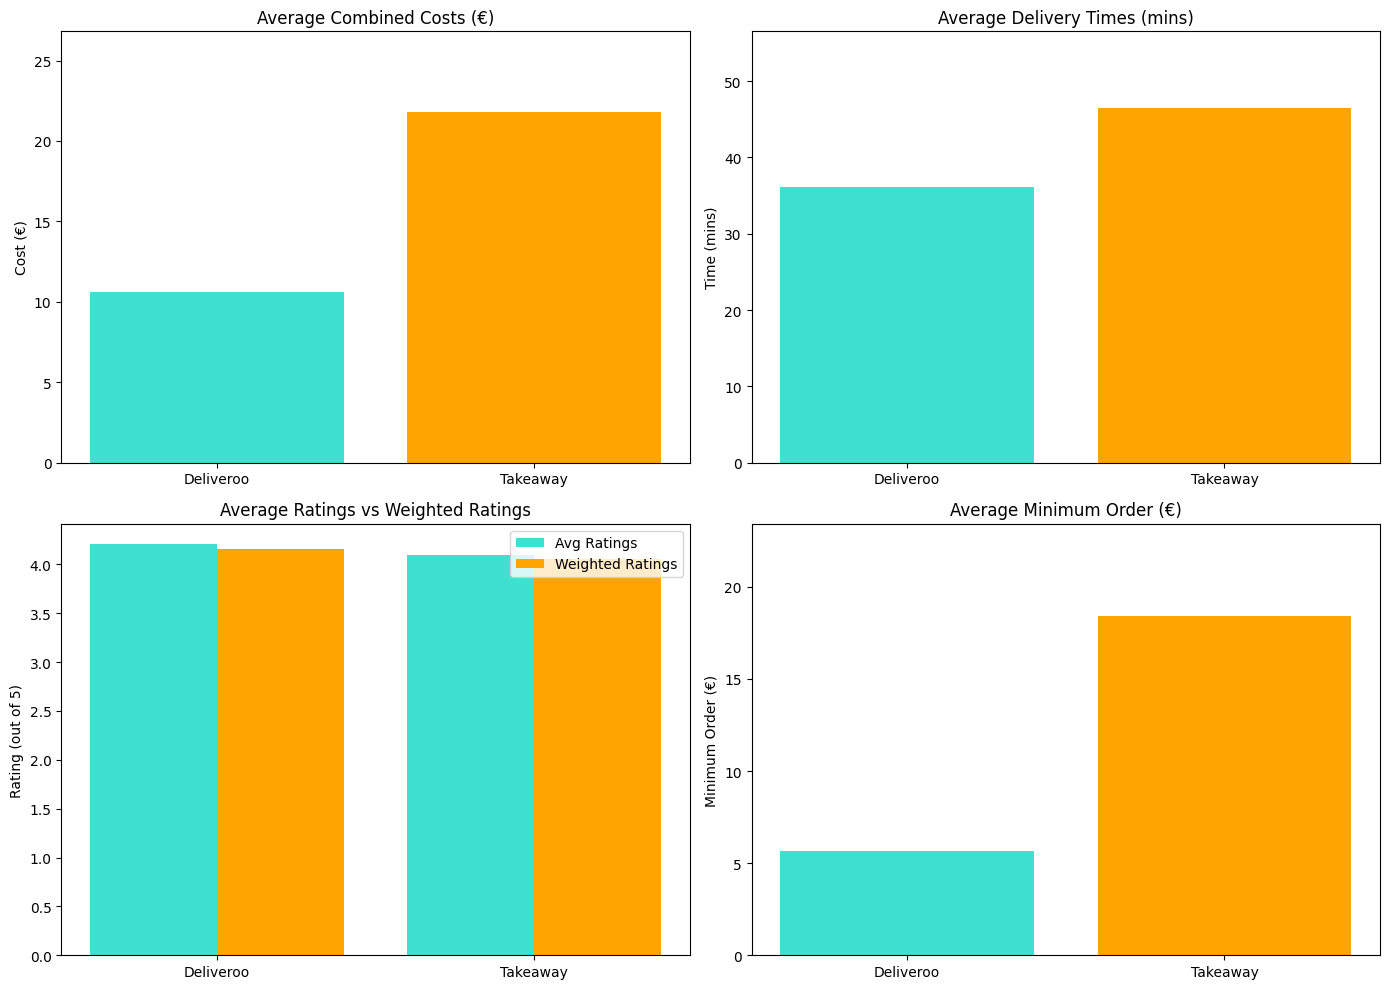

Insights:
1. Combined Costs: Deliveroo (10.63€) is lower than Takeaway (21.81€).
2. Delivery Times: Deliveroo (36.16 mins) is faster than Takeaway (46.51 mins).
3. Ratings: Deliveroo has slightly higher average ratings (4.20) compared to Takeaway (4.10).
4. Weighted Ratings: Deliveroo (4.16) is more consistent than Takeaway (4.06).
5. Minimum Order Value: Deliveroo (5.68€) is lower than Takeaway (18.42€).


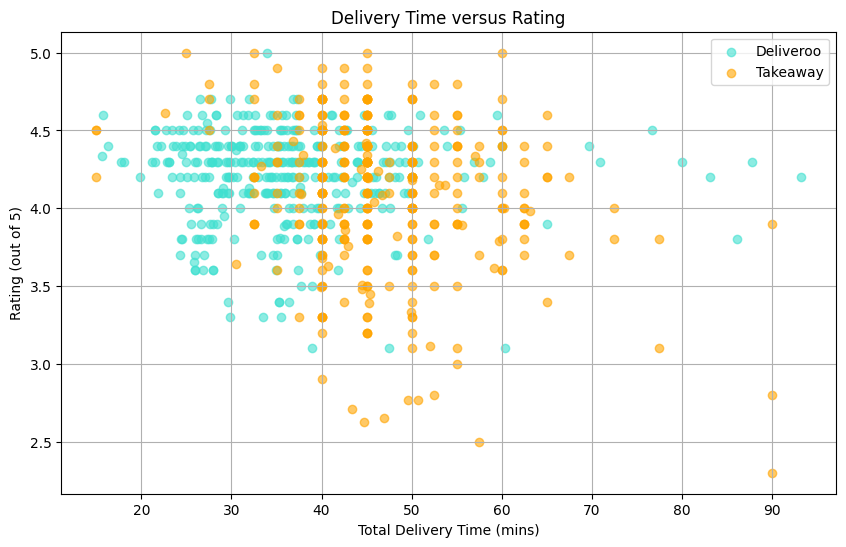

Insights on Delivery Time versus Rating:
1. Deliveroo: There seems to be a slight trend where shorter delivery times are associated with higher ratings.
2. Takeaway: The trend is less clear, but there is a general tendency for higher ratings with shorter delivery times.
Average Delivery Time (Deliveroo): 36.16 mins
Average Delivery Time (Takeaway): 46.51 mins
Average Minimum Order Value (Deliveroo): 5.68€
Average Minimum Order Value (Takeaway): 18.42€
Average Combined Cost (Deliveroo): 10.63€
Average Combined Cost (Takeaway): 21.81€
Average Delivery Fee (Deliveroo): 4.95€
Average Delivery Fee (Takeaway): 3.40€
Count of unique datapoints:
restaurant_name_clean            355
combined_cost_deliveroo           20
combined_cost_takeaway           103
delivery_fee_deliveroo             6
delivery_fee_takeaway             64
min_order_deliveroo               15
min_order_takeaway                63
rating_deliveroo                  30
rating_takeaway                   71
rating_count_delivero

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'mutual_analysis.csv'
data = pd.read_csv(file_path)

# Summary Statistics
platforms = ['Deliveroo', 'Takeaway']
avg_costs = [data['combined_cost_deliveroo'].mean(), data['combined_cost_takeaway'].mean()]
avg_delivery_times = [data['total_delivery_time_deliveroo'].mean(), data['total_delivery_time_takeaway'].mean()]
avg_ratings = [data['rating_deliveroo'].mean(), data['rating_takeaway'].mean()]
weighted_ratings = [data['weighted_rating_deliveroo'].mean(), data['weighted_rating_takeaway'].mean()]
min_order_means = [data['min_order_deliveroo'].mean(), data['min_order_takeaway'].mean()]
min_order_median = [data['min_order_deliveroo'].median(), data['min_order_takeaway'].median()]

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Combined Costs Comparison
axes[0, 0].bar(platforms, avg_costs, color=['turquoise', 'orange'])
axes[0, 0].set_title('Average Combined Costs (€)')
axes[0, 0].set_ylabel('Cost (€)')
axes[0, 0].set_ylim(0, max(avg_costs) + 5)

# Delivery Times Comparison
axes[0, 1].bar(platforms, avg_delivery_times, color=['turquoise', 'orange'])
axes[0, 1].set_title('Average Delivery Times (mins)')
axes[0, 1].set_ylabel('Time (mins)')
axes[0, 1].set_ylim(0, max(avg_delivery_times) + 10)

# Ratings Comparison
x = [0, 1]  # x positions for the platforms
axes[1, 0].bar(x, avg_ratings, width=0.4, label='Avg Ratings', color='turquoise', align='center')
axes[1, 0].bar([i + 0.4 for i in x], weighted_ratings, width=0.4, label='Weighted Ratings', color='orange', align='center')
axes[1, 0].set_title('Average Ratings vs Weighted Ratings')
axes[1, 0].set_xticks([i + 0.2 for i in x])
axes[1, 0].set_xticklabels(platforms)
axes[1, 0].set_ylabel('Rating (out of 5)')
axes[1, 0].legend()

# Minimum Order Value Comparison
axes[1, 1].bar(platforms, min_order_means, color=['turquoise', 'orange'])
axes[1, 1].set_title('Average Minimum Order (€)')
axes[1, 1].set_ylabel('Minimum Order (€)')
axes[1, 1].set_ylim(0, max(min_order_means) + 5)

plt.tight_layout()
plt.show()

# Insights
print("Insights:")
print(f"1. Combined Costs: Deliveroo ({avg_costs[0]:.2f}€) is lower than Takeaway ({avg_costs[1]:.2f}€).")
print(f"2. Delivery Times: Deliveroo ({avg_delivery_times[0]:.2f} mins) is faster than Takeaway ({avg_delivery_times[1]:.2f} mins).")
print(f"3. Ratings: Deliveroo has slightly higher average ratings ({avg_ratings[0]:.2f}) compared to Takeaway ({avg_ratings[1]:.2f}).")
print(f"4. Weighted Ratings: Deliveroo ({weighted_ratings[0]:.2f}) is more consistent than Takeaway ({weighted_ratings[1]:.2f}).")
print(f"5. Minimum Order Value: Deliveroo ({min_order_means[0]:.2f}€) is lower than Takeaway ({min_order_means[1]:.2f}€).")


# Delivery Time versus Rating
plt.figure(figsize=(10, 6))
plt.scatter(data['total_delivery_time_deliveroo'], data['rating_deliveroo'], color='turquoise', label='Deliveroo', alpha=0.6)
plt.scatter(data['total_delivery_time_takeaway'], data['rating_takeaway'], color='orange', label='Takeaway', alpha=0.6)
plt.title('Delivery Time versus Rating')
plt.xlabel('Total Delivery Time (mins)')
plt.ylabel('Rating (out of 5)')
plt.legend()
plt.grid(True)
plt.show()

# Insights on Delivery Time versus Rating
print("Insights on Delivery Time versus Rating:")
print("1. Deliveroo: There seems to be a slight trend where shorter delivery times are associated with higher ratings.")
print("2. Takeaway: The trend is less clear, but there is a general tendency for higher ratings with shorter delivery times.")


# Calculate average delivery time, minimum order value, and combined costs for Deliveroo and Takeaway
avg_delivery_time_deliveroo = data['total_delivery_time_deliveroo'].mean()
avg_delivery_time_takeaway = data['total_delivery_time_takeaway'].mean()

avg_min_order_deliveroo = data['min_order_deliveroo'].mean()
avg_min_order_takeaway = data['min_order_takeaway'].mean()

avg_combined_cost_deliveroo = data['combined_cost_deliveroo'].mean()
avg_combined_cost_takeaway = data['combined_cost_takeaway'].mean()

print(f"Average Delivery Time (Deliveroo): {avg_delivery_time_deliveroo:.2f} mins")
print(f"Average Delivery Time (Takeaway): {avg_delivery_time_takeaway:.2f} mins")
print(f"Average Minimum Order Value (Deliveroo): {avg_min_order_deliveroo:.2f}€")
print(f"Average Minimum Order Value (Takeaway): {avg_min_order_takeaway:.2f}€")
print(f"Average Combined Cost (Deliveroo): {avg_combined_cost_deliveroo:.2f}€")
print(f"Average Combined Cost (Takeaway): {avg_combined_cost_takeaway:.2f}€")   

# Calculate average delivery fee for Deliveroo and Takeaway
avg_delivery_fee_deliveroo = data['delivery_fee_deliveroo'].mean()
avg_delivery_fee_takeaway = data['delivery_fee_takeaway'].mean()

print(f"Average Delivery Fee (Deliveroo): {avg_delivery_fee_deliveroo:.2f}€")
print(f"Average Delivery Fee (Takeaway): {avg_delivery_fee_takeaway:.2f}€")

# Count of unique datapoints
unique_datapoints = data.nunique()
print("Count of unique datapoints:")
print(unique_datapoints)

# Calculate median delivery fee for Deliveroo and Takeaway
median_delivery_fee_deliveroo = data['delivery_fee_deliveroo'].median()
median_delivery_fee_takeaway = data['delivery_fee_takeaway'].median()

print(f"Median Delivery Fee (Deliveroo): {median_delivery_fee_deliveroo:.2f}€")
print(f"Median Delivery Fee (Takeaway): {median_delivery_fee_takeaway:.2f}€")

# Show average and median delivery fees
print(f"Average Delivery Fee (Deliveroo): {avg_delivery_fee_deliveroo:.2f}€")
print(f"Average Delivery Fee (Takeaway): {avg_delivery_fee_takeaway:.2f}€")
print(f"Median Delivery Fee (Deliveroo): {median_delivery_fee_deliveroo:.2f}€")
print(f"Median Delivery Fee (Takeaway): {median_delivery_fee_takeaway:.2f}€")

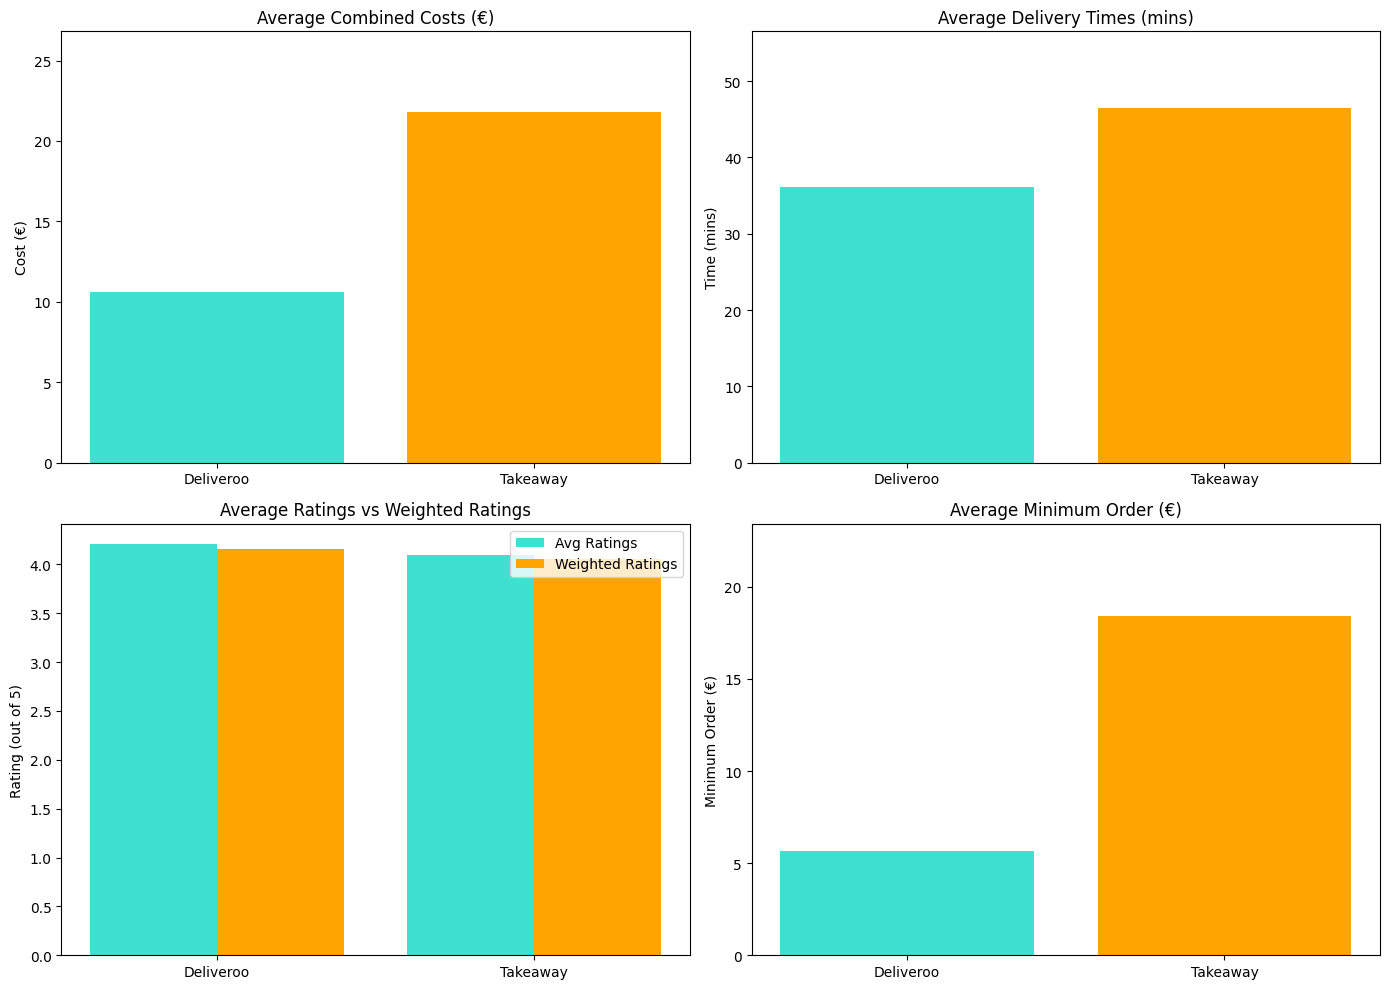

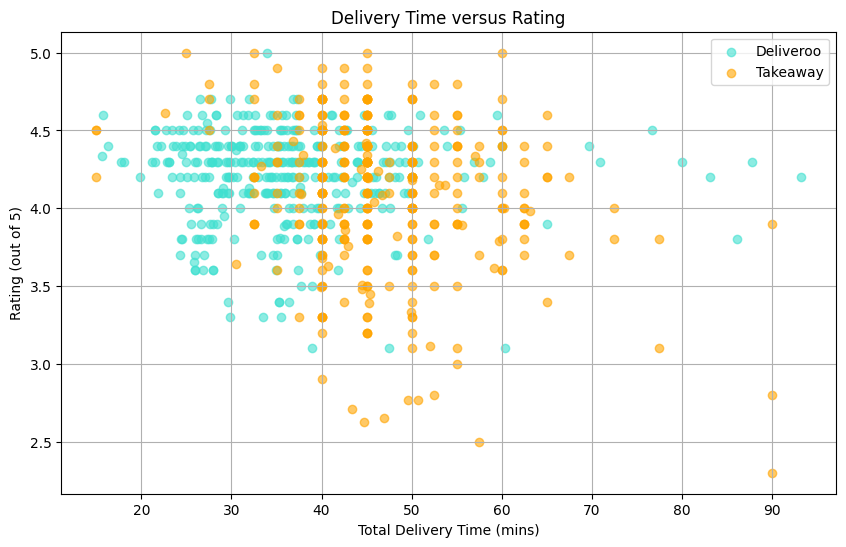

In [8]:
import matplotlib.pyplot as plt

# Data for plotting
platforms = ['Deliveroo', 'Takeaway']
avg_costs = [data['combined_cost_deliveroo'].mean(), data['combined_cost_takeaway'].mean()]
avg_delivery_times = [data['total_delivery_time_deliveroo'].mean(), data['total_delivery_time_takeaway'].mean()]
avg_ratings = [data['rating_deliveroo'].mean(), data['rating_takeaway'].mean()]
weighted_ratings = [data['weighted_rating_deliveroo'].mean(), data['weighted_rating_takeaway'].mean()]
min_order_means = [data['min_order_deliveroo'].mean(), data['min_order_takeaway'].mean()]

# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot Average Combined Costs
axes[0, 0].bar(platforms, avg_costs, color=['turquoise', 'orange'])
axes[0, 0].set_title('Average Combined Costs (€)')
axes[0, 0].set_ylabel('Cost (€)')
axes[0, 0].set_ylim(0, max(avg_costs) + 5)

# Plot Average Delivery Times
axes[0, 1].bar(platforms, avg_delivery_times, color=['turquoise', 'orange'])
axes[0, 1].set_title('Average Delivery Times (mins)')
axes[0, 1].set_ylabel('Time (mins)')
axes[0, 1].set_ylim(0, max(avg_delivery_times) + 10)

# Plot Ratings (Average and Weighted)
x = [0, 1]  # X positions for the platforms
axes[1, 0].bar(x, avg_ratings, width=0.4, label='Avg Ratings', color='turquoise', align='center')
axes[1, 0].bar([i + 0.4 for i in x], weighted_ratings, width=0.4, label='Weighted Ratings', color='orange', align='center')
axes[1, 0].set_title('Average Ratings vs Weighted Ratings')
axes[1, 0].set_xticks([i + 0.2 for i in x])
axes[1, 0].set_xticklabels(platforms)
axes[1, 0].set_ylabel('Rating (out of 5)')
axes[1, 0].legend()

# Plot Average Minimum Order Value
axes[1, 1].bar(platforms, min_order_means, color=['turquoise', 'orange'])
axes[1, 1].set_title('Average Minimum Order (€)')
axes[1, 1].set_ylabel('Minimum Order (€)')
axes[1, 1].set_ylim(0, max(min_order_means) + 5)

plt.tight_layout()
plt.show()

# Scatter Plot for Delivery Time vs Ratings
plt.figure(figsize=(10, 6))
plt.scatter(data['total_delivery_time_deliveroo'], data['rating_deliveroo'], color='turquoise', label='Deliveroo', alpha=0.6)
plt.scatter(data['total_delivery_time_takeaway'], data['rating_takeaway'], color='orange', label='Takeaway', alpha=0.6)
plt.title('Delivery Time versus Rating')
plt.xlabel('Total Delivery Time (mins)')
plt.ylabel('Rating (out of 5)')
plt.legend()
plt.grid(True)
plt.show()


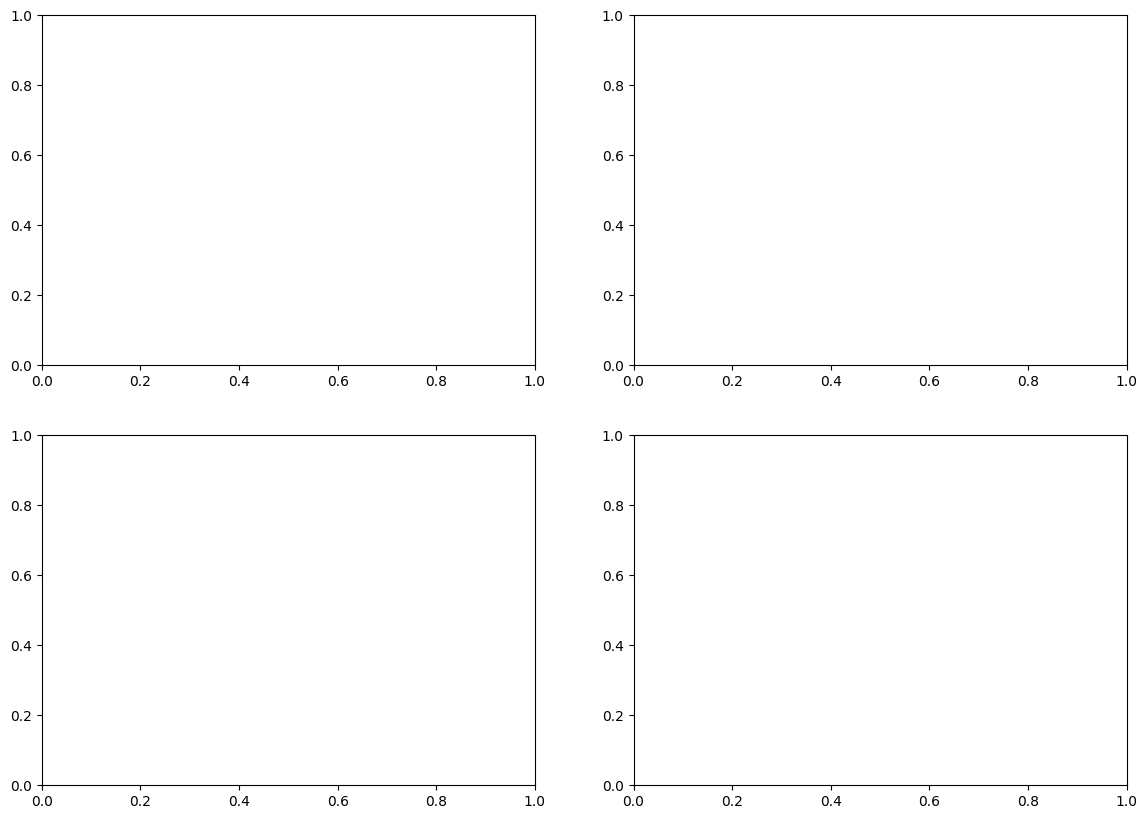

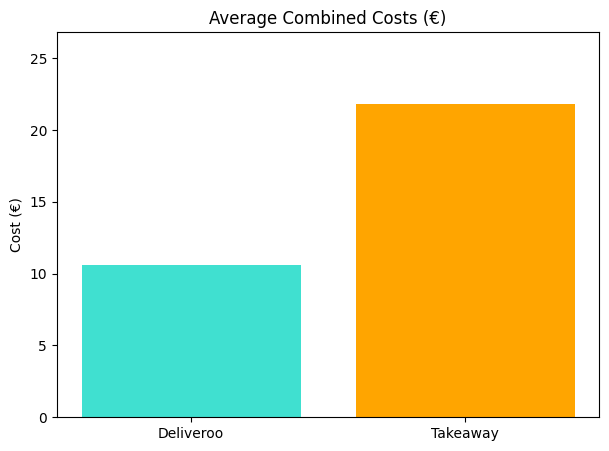

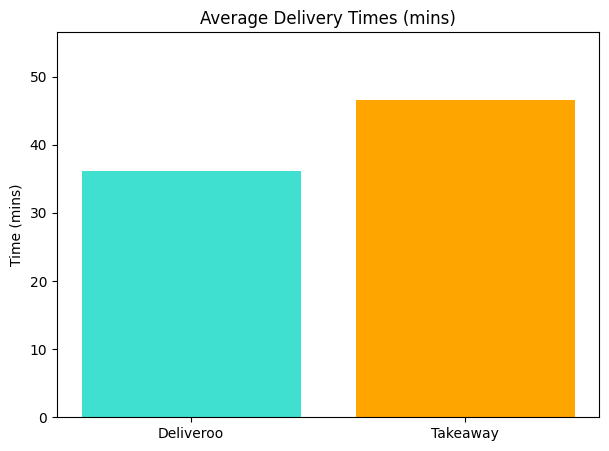

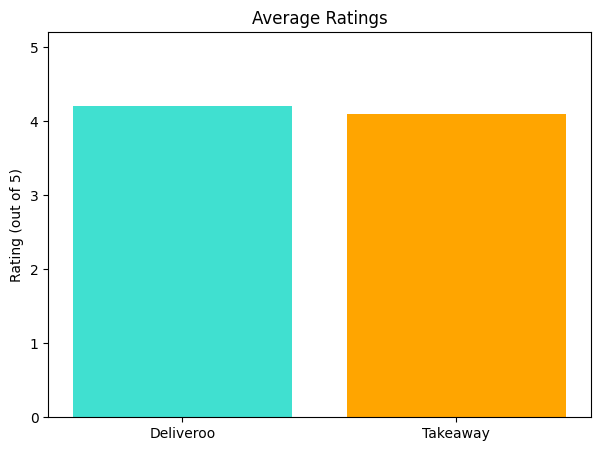

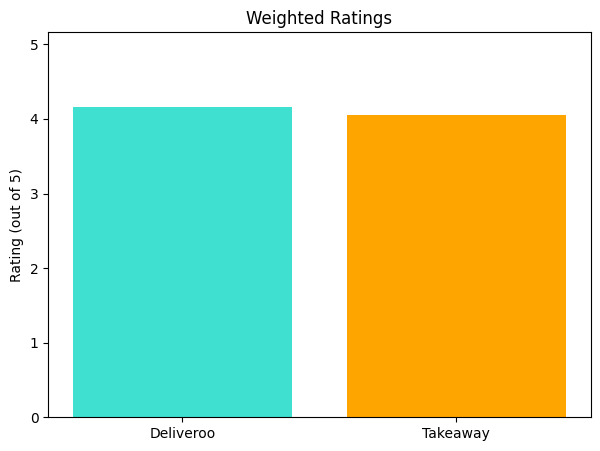

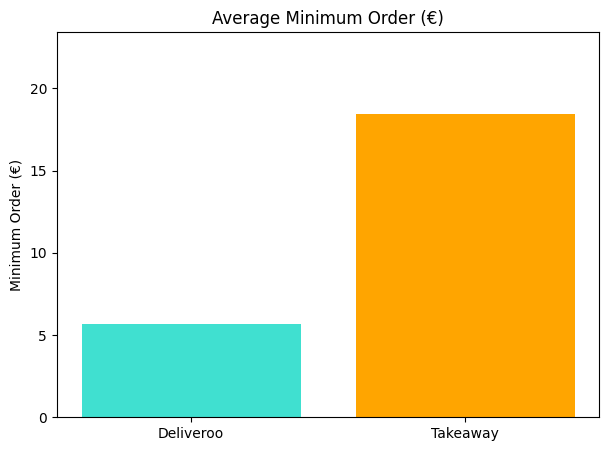

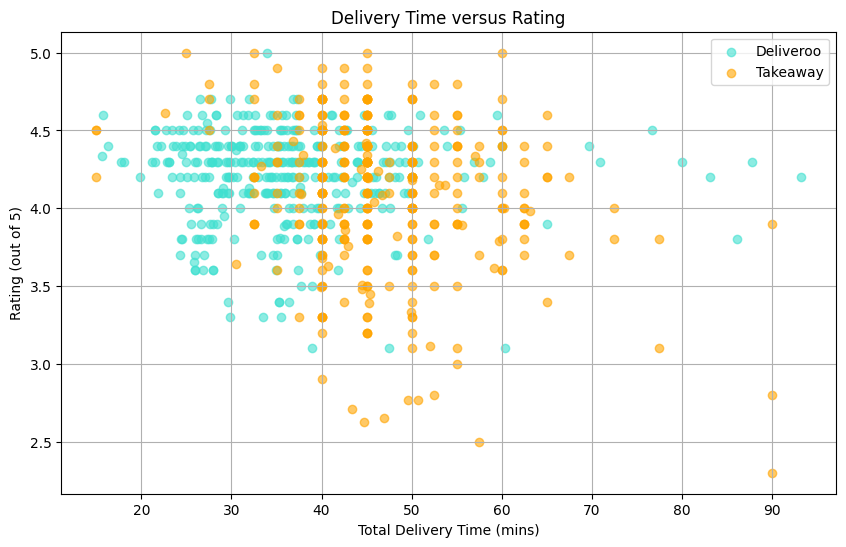

In [9]:
import matplotlib.pyplot as plt

# Data for plotting
platforms = ['Deliveroo', 'Takeaway']
avg_costs = [data['combined_cost_deliveroo'].mean(), data['combined_cost_takeaway'].mean()]
avg_delivery_times = [data['total_delivery_time_deliveroo'].mean(), data['total_delivery_time_takeaway'].mean()]
avg_ratings = [data['rating_deliveroo'].mean(), data['rating_takeaway'].mean()]
weighted_ratings = [data['weighted_rating_deliveroo'].mean(), data['weighted_rating_takeaway'].mean()]
min_order_means = [data['min_order_deliveroo'].mean(), data['min_order_takeaway'].mean()]

# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot Average Combined Costs
plt.figure(figsize=(7, 5))
plt.bar(platforms, avg_costs, color=['turquoise', 'orange'])
plt.title('Average Combined Costs (€)')
plt.ylabel('Cost (€)')
plt.ylim(0, max(avg_costs) + 5)
plt.show()

# Plot Average Delivery Times
plt.figure(figsize=(7, 5))
plt.bar(platforms, avg_delivery_times, color=['turquoise', 'orange'])
plt.title('Average Delivery Times (mins)')
plt.ylabel('Time (mins)')
plt.ylim(0, max(avg_delivery_times) + 10)
plt.show()

# Plot Average Ratings
plt.figure(figsize=(7, 5))
plt.bar(platforms, avg_ratings, color=['turquoise', 'orange'])
plt.title('Average Ratings')
plt.ylabel('Rating (out of 5)')
plt.ylim(0, max(avg_ratings) + 1)
plt.show()

# Plot Weighted Ratings
plt.figure(figsize=(7, 5))
plt.bar(platforms, weighted_ratings, color=['turquoise', 'orange'])
plt.title('Weighted Ratings')
plt.ylabel('Rating (out of 5)')
plt.ylim(0, max(weighted_ratings) + 1)
plt.show()

# Plot Average Minimum Order Value
plt.figure(figsize=(7, 5))
plt.bar(platforms, min_order_means, color=['turquoise', 'orange'])
plt.title('Average Minimum Order (€)')
plt.ylabel('Minimum Order (€)')
plt.ylim(0, max(min_order_means) + 5)
plt.show()

# Scatter Plot for Delivery Time vs Ratings
plt.figure(figsize=(10, 6))
plt.scatter(data['total_delivery_time_deliveroo'], data['rating_deliveroo'], color='turquoise', label='Deliveroo', alpha=0.6)
plt.scatter(data['total_delivery_time_takeaway'], data['rating_takeaway'], color='orange', label='Takeaway', alpha=0.6)
plt.title('Delivery Time versus Rating')
plt.xlabel('Total Delivery Time (mins)')
plt.ylabel('Rating (out of 5)')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
import os
import sqlite3
import pandas as pd

def load_restaurant_data(db_file, db_id, c, m=50):
    """Load and calculate weighted ratings for restaurant data from specified database."""
    if not os.path.exists(db_file):
        print(f"Error: {db_file} does not exist.")
        return pd.DataFrame()

    # Define queries for each database
    queries = {
        "deliveroo": f"""
            SELECT 
                name AS restaurant_name, 
                address, postal_code, uname AS unique_restaurant_id,
                CAST(longitude AS REAL) AS longitude, 
                CAST(latitude AS REAL) AS latitude, 
                rating, CAST(rating_number AS INTEGER) AS rating_count,
                ((rating_number * rating) + ({m} * {c})) / (rating_number + {m}) AS weighted_rating,
                prep_time, delivery_time, 
                ROUND(CAST(prep_time AS REAL) + CAST(delivery_time AS REAL), 2) AS total_delivery_time,
                COALESCE(delivery_fee, 0) AS delivery_fee, 
                COALESCE(min_order, 0) AS min_order,
                ROUND(COALESCE(CAST(delivery_fee AS REAL), 0) + COALESCE(CAST(min_order AS REAL), 0), 2) AS combined_cost
            FROM restaurants
            WHERE rating IS NOT NULL 
              AND rating_number > 0
              AND (delivery_fee IS NOT NULL OR min_order IS NOT NULL)
        """,
        "takeaway": f"""
            SELECT 
                r.name AS restaurant_name, 
                r.address, r.city, r.primarySlug AS unique_restaurant_id,
                CAST(r.longitude AS REAL) AS longitude, 
                CAST(r.latitude AS REAL) AS latitude, 
                r.ratings AS rating, CAST(r.ratingsNumber AS INTEGER) AS rating_count,
                ((r.ratingsNumber * r.ratings) + ({m} * {c})) / (r.ratingsNumber + {m}) AS weighted_rating,
                l.postalCode AS postal_code,
                COALESCE(r.deliveryFee, 0) AS delivery_fee, 
                COALESCE(r.minOrder, 0) AS min_order,
                ROUND(COALESCE(CAST(r.deliveryFee AS REAL), 0) + COALESCE(CAST(r.minOrder AS REAL), 0), 2) AS combined_cost,
                ROUND((CAST(r.durationRangeMin AS REAL) + CAST(r.durationRangeMax AS REAL)) / 2, 2) AS total_delivery_time
            FROM restaurants r
            LEFT JOIN (
                SELECT
                    lr.restaurant_id, l.postalCode
                FROM locations_to_restaurants lr
                JOIN locations l ON lr.location_id = l.ID
                WHERE l.postalCode IS NOT NULL
            ) l ON r.primarySlug = l.restaurant_id
            WHERE r.ratings IS NOT NULL 
              AND r.ratingsNumber > 0
        """
    }

    try:
        # Connect to the database and execute the query
        conn = sqlite3.connect(db_file)
        df = pd.read_sql_query(queries[db_id], conn)
        if df.empty:
            print(f"Warning: No data found in {db_id}.")
        df['source'] = db_id  # Add source identifier
        return df
    except sqlite3.OperationalError as e:
        print(f"Error querying {db_id}: {e}")
        return pd.DataFrame()
    finally:
        conn.close()

# Define database files and identifiers
db_files = [
    ("databases_uc/deliveroo.db", "deliveroo"),
    ("databases_uc/takeaway.db", "takeaway")
]

# Load and combine data
dataframes = [load_restaurant_data(file, db_id, c=4.0, m=50) for file, db_id in db_files]
stacked_df = pd.concat(dataframes, ignore_index=True)

# Fill missing values
stacked_df['city'] = stacked_df.get('city', pd.Series()).fillna("Unknown")
stacked_df['postal_code'] = stacked_df.get('postal_code', pd.Series()).fillna("Unknown")
stacked_df['address'] = stacked_df['address'].fillna("Unknown")
stacked_df['rating'] = stacked_df['rating'].fillna(0.0)
stacked_df['delivery_fee'] = stacked_df['delivery_fee'].fillna(0.0)
stacked_df['min_order'] = stacked_df['min_order'].fillna(0.0)
stacked_df['total_delivery_time'] = stacked_df['total_delivery_time'].fillna("Unknown")
stacked_df['combined_cost'] = stacked_df['combined_cost'].fillna(0.0)

# Drop duplicates based on restaurant name and source
stacked_df = stacked_df.drop_duplicates(subset=['restaurant_name', 'address', 'source'])

# Sort by weighted_rating
stacked_df = stacked_df.sort_values(by='weighted_rating', ascending=False)

# Display the processed data
print(f"Total rows after processing: {stacked_df.shape[0]}")
print(stacked_df.head())


Total rows after processing: 5319
               restaurant_name                     address postal_code  \
59738  De Echte Eethuis Carlos       Herseltsesteenweg 207        2230   
8438                 Veziroglu  Franklin Rooseveltlaan 100        1800   
2633            Snack Thieffry              Rue Pervyse 62        1140   
4068                 Sushiline     Chaussée De Louvain 470        1140   
60904              Snack Dekan   Place Cardinal Mercier 41        1731   

          unique_restaurant_id  longitude   latitude  rating  rating_count  \
59738  eethuis-carlos-aarschot   4.835920  51.002308     5.0           599   
8438                 veziroglu   4.425172  50.931044     5.0           455   
2633            snack-thieffry   4.399869  50.830792     4.9          3875   
4068       sushiline-bruxelles   4.391012  50.853172     4.9          3036   
60904              snack-dekan   4.329693  50.880092     4.9          2845   

       weighted_rating  prep_time  delivery_time  to

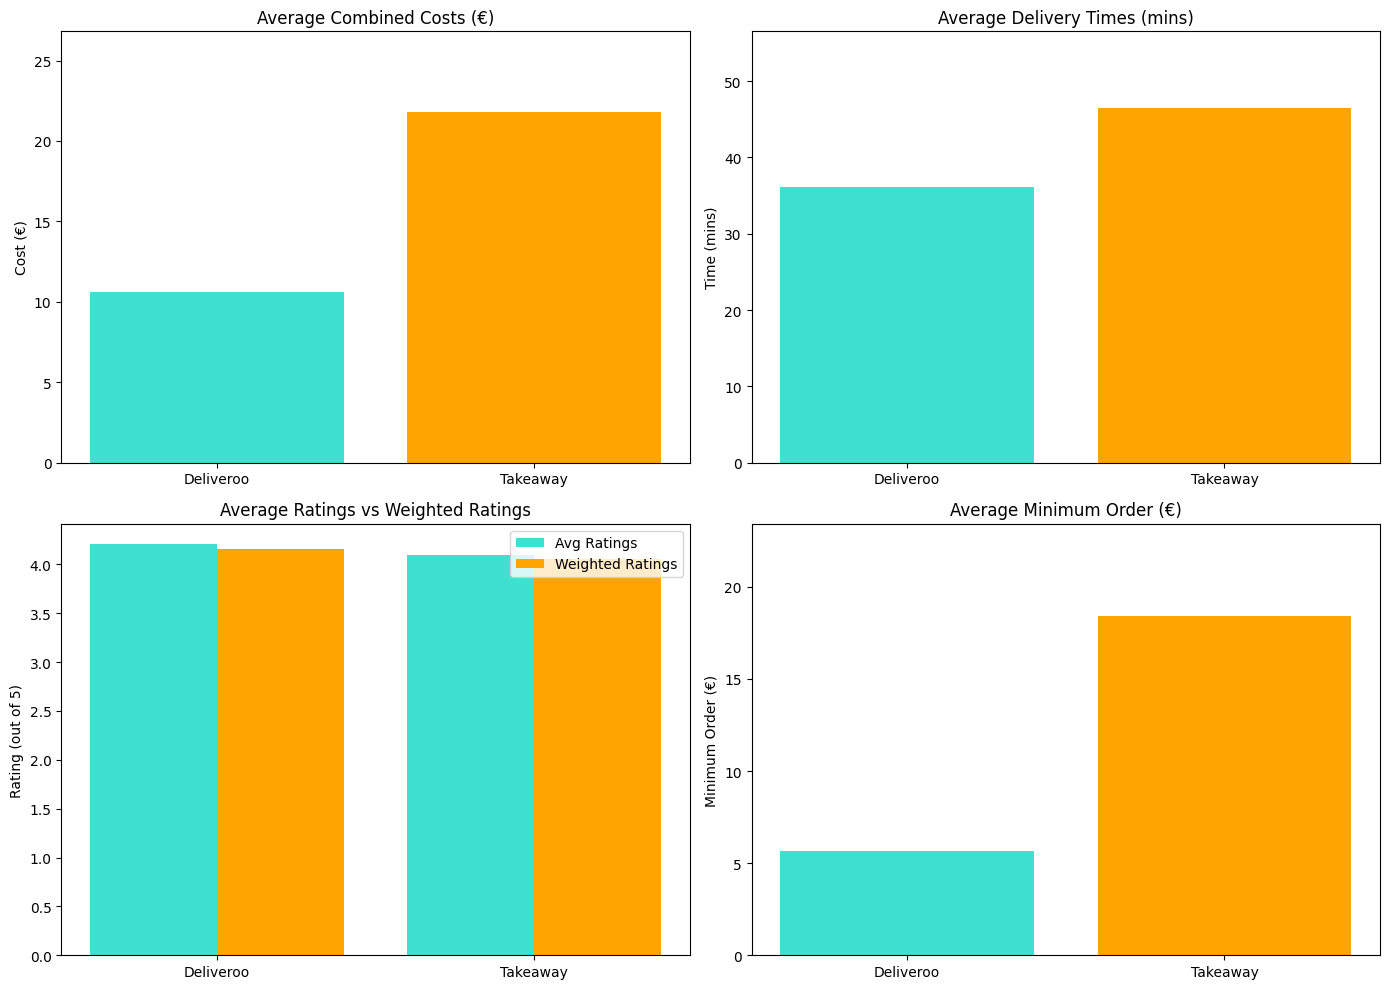

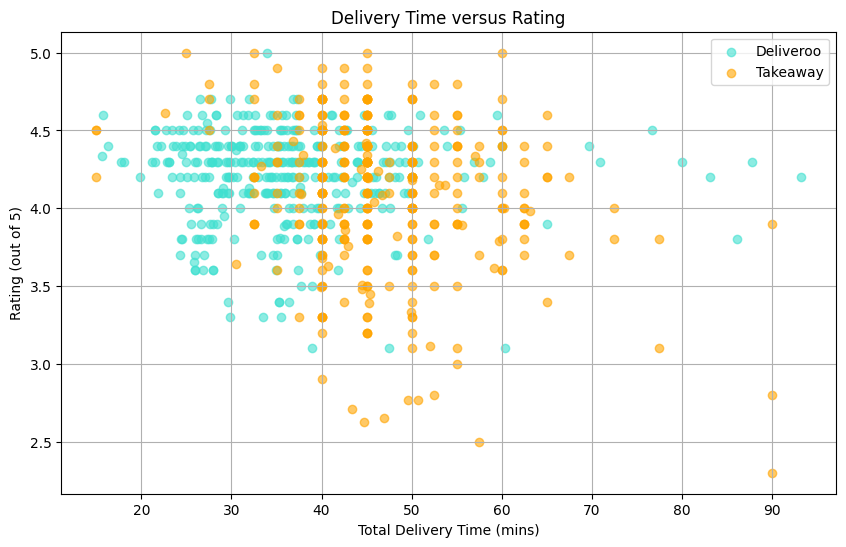

In [11]:
import matplotlib.pyplot as plt

# Data for plotting
platforms = ['Deliveroo', 'Takeaway']
avg_costs = [data['combined_cost_deliveroo'].mean(), data['combined_cost_takeaway'].mean()]
avg_delivery_times = [data['total_delivery_time_deliveroo'].mean(), data['total_delivery_time_takeaway'].mean()]
avg_ratings = [data['rating_deliveroo'].mean(), data['rating_takeaway'].mean()]
weighted_ratings = [data['weighted_rating_deliveroo'].mean(), data['weighted_rating_takeaway'].mean()]
min_order_means = [data['min_order_deliveroo'].mean(), data['min_order_takeaway'].mean()]

# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot Average Combined Costs
axes[0, 0].bar(platforms, avg_costs, color=['turquoise', 'orange'])
axes[0, 0].set_title('Average Combined Costs (€)')
axes[0, 0].set_ylabel('Cost (€)')
axes[0, 0].set_ylim(0, max(avg_costs) + 5)

# Plot Average Delivery Times
axes[0, 1].bar(platforms, avg_delivery_times, color=['turquoise', 'orange'])
axes[0, 1].set_title('Average Delivery Times (mins)')
axes[0, 1].set_ylabel('Time (mins)')
axes[0, 1].set_ylim(0, max(avg_delivery_times) + 10)

# Plot Ratings (Average and Weighted)
x = [0, 1]  # X positions for the platforms
axes[1, 0].bar(x, avg_ratings, width=0.4, label='Avg Ratings', color='turquoise', align='center')
axes[1, 0].bar([i + 0.4 for i in x], weighted_ratings, width=0.4, label='Weighted Ratings', color='orange', align='center')
axes[1, 0].set_title('Average Ratings vs Weighted Ratings')
axes[1, 0].set_xticks([i + 0.2 for i in x])
axes[1, 0].set_xticklabels(platforms)
axes[1, 0].set_ylabel('Rating (out of 5)')
axes[1, 0].legend()

# Plot Average Minimum Order Value
axes[1, 1].bar(platforms, min_order_means, color=['turquoise', 'orange'])
axes[1, 1].set_title('Average Minimum Order (€)')
axes[1, 1].set_ylabel('Minimum Order (€)')
axes[1, 1].set_ylim(0, max(min_order_means) + 5)

plt.tight_layout()
plt.show()

# Scatter Plot for Delivery Time vs Ratings
plt.figure(figsize=(10, 6))
plt.scatter(data['total_delivery_time_deliveroo'], data['rating_deliveroo'], color='turquoise', label='Deliveroo', alpha=0.6)
plt.scatter(data['total_delivery_time_takeaway'], data['rating_takeaway'], color='orange', label='Takeaway', alpha=0.6)
plt.title('Delivery Time versus Rating')
plt.xlabel('Total Delivery Time (mins)')
plt.ylabel('Rating (out of 5)')
plt.legend()
plt.grid(True)
plt.show()
